In [39]:
import pyaudio
import wave
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from IPython.display import Audio, display, Image


def load_and_preprocess_data_librosa_mel_spectrogram(file_path):
    """
    Function called inside create dataset, it loads from the file a single sample and extracts the mfcc features
    :param file_path: path of the sample considered
    :return: mel spectrogram of the audio file
    """


    y, sr = librosa.load(file_path, 16000)
    N = y.shape[0]
    #print(N)
    target_size = 16000
    if N < target_size:
        tot_pads = target_size - N
        left_pads = int(np.ceil(tot_pads / 2))
        right_pads = int(np.floor(tot_pads / 2))
        y = np.pad(y, [left_pads, right_pads], mode='constant', constant_values=(0, 0))
    elif N < target_size:
        from_ = int((N / 2) - (target_size / 2))
        to_ = from_ + target_size
        y = y[from_:to_]
    y = normalize_data(y)
    #y = librosa.util.normalize(y)
    librosa_melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024,
                                                     hop_length=128, power=1.0,  # window='hann',
                                                     n_mels=80, fmin=40.0, fmax=sr / 2)

    S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)


    S_dB = S_dB.reshape((S_dB.shape[0], S_dB.shape[1], 1))
    result = normalize_data(S_dB)
    #result = librosa.util.normalize(S_dB)
    return result.astype(np.float32)

def normalize_data(data):
    """
    normalize sample
    :param data: input data
    :return: normalized data
    """
    # Amplitude estimate
    norm_factor = np.percentile(data, 99) - np.percentile(data, 5)

    return data / norm_factor

def record_sample():

    chunk = 1024  # Record in chunks of 1024 samples
    sample_format = pyaudio.paInt16  # 16 bits per sample
    channels = 1
    fs = 16000  
    seconds = 1
    filename = "output.wav"

    p = pyaudio.PyAudio()  # Create an interface to PortAudio

    print('Recording in 3,')
    time.sleep(1)
    print('Recording in 2,')
    time.sleep(1)
    print('Recording in 1,')
    time.sleep(1)
    print('Recording...')

    stream = p.open(format=sample_format,
                    channels=channels,
                    rate=fs,
                    frames_per_buffer=chunk,
                    input=True)

    frames = []  # Initialize array to store frames

    # Store data in chunks for 3 seconds
    for i in range(0, int(fs / chunk * seconds)):
        data = stream.read(chunk)
        frames.append(data)

    # Stop and close the stream 
    stream.stop_stream()
    stream.close()
    # Terminate the PortAudio interface
    p.terminate()

    print('Finished recording')

    # Save the recorded data as a WAV file
    wf = wave.open(filename, 'wb')
    wf.setnchannels(channels)
    wf.setsampwidth(p.get_sample_size(sample_format))
    wf.setframerate(fs)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    
    
    
def AttRNNSpeechModel80K(input_shape, classes, rnn_func=tf.keras.layers.GRU):
    X_input = tf.keras.Input(input_shape)

    # note that Melspectrogram puts the sequence in shape (batch_size, melDim, timeSteps, 1)
    # we would rather have it the other way around for LSTMs

    x = tf.keras.layers.Permute((2, 1, 3))(X_input)

    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Lambda(lambda q: tf.keras.backend.squeeze(q, -1), name='squeeze_last_dim')(x) # since we only have one filter the output is back to being a single image
    x = tf.keras.layers.Bidirectional(rnn_func(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]
    #x = tf.keras.layers.Bidirectional(rnn_func(64, return_sequences=True))(x)  # [b_s, seq_len, vec_dim]

    xFirst = tf.keras.layers.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    query = tf.keras.layers.Dense(128)(xFirst)

    # dot product attention
    attScores = tf.keras.layers.Dot(axes=[1, 2])([query, x])
    attScores = tf.keras.layers.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # rescale sequence
    attVector = tf.keras.layers.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    x = tf.keras.layers.Dense(64, activation='relu')(attVector)

    x = tf.keras.layers.Dense(32, activation='relu')(x)


    output = tf.keras.layers.Dense(classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=[X_input], outputs=[output], name='AttRNNSpeechModel80K')

    return model

def continuous_detection():
    with tf.device("/cpu:0"):
#     model = AttRNNSpeechModel80K((80, 126, 1), classes)

#     model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

        model = tf.keras.models.load_model('ModelEntireDatasetPartitioned_AttRNNSpeechModel80K_0.512_cl.h5')

        #model.summary()
        CHUNKSIZE = 8000 # fixed chunk size
        RATE = 16000
        sr = 16000
        first = True
        sample = 1
        # initialize portaudio
        p = pyaudio.PyAudio()
        stream = p.open(format=pyaudio.paFloat32, channels=1, rate=RATE, input=True, frames_per_buffer=CHUNKSIZE)


        previous_chunk = np.zeros(8000)
        now = time.time()
        future = now + 5
        while(time.time() < future):
            
            data = stream.read(CHUNKSIZE)
            data = np.frombuffer(data, dtype=np.float32)
            
            if(first):
                previous_chunk=data
                first = False
            else:
                print("sample ", sample, ' = ', end='')
                current_sample = np.concatenate((previous_chunk,data))
                #librosa.display.waveplot(current_sample, sr=RATE)
                #plt.close('all')
                y = normalize_data(current_sample)
                librosa_melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024,
                                                         hop_length=128, power=1.0,  # window='hann',
                                                         n_mels=80, fmin=40.0, fmax=sr / 2)

                S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)


                S_dB = S_dB.reshape((S_dB.shape[0], S_dB.shape[1], 1))
                result = normalize_data(S_dB)
                spectrogram=np.resize(result,(1,80,126,1))

#                 print(spectrogram.shape)
#                 plt.figure(figsize=(17, 6))
#                 plt.pcolormesh(spectrogram[0,:,:,0])
#                 plt.title('Spectrogram visualization')
#                 plt.ylabel('Frequency')
#                 plt.xlabel('Time')
#                 plt.colorbar()
#                 plt.show()

                prediction = model.predict(spectrogram)
#                 print(prediction)
#                 print(dict[np.argmax(prediction)])
                if np.max(prediction)>0.98:
                    print(dict[np.argmax(prediction)])
                else:
                    print("silence")
                previous_chunk = data
            


        # close stream
        stream.stop_stream()
        stream.close()
        p.terminate()


In [42]:
continuous_detection()

sample  1  = silence
sample  1  = silence
sample  1  = silence
sample  1  = silence
sample  1  = silence
sample  1  = silence
sample  1  = silence
sample  1  = unknown
sample  1  = silence


In [11]:
record_sample()


Recording in 3,
Recording in 2,
Recording in 1,
Recording...
Finished recording


In [2]:
y, sr = librosa.load("output.wav", 16000)

Audio(data=y, rate=sr)

(80, 126, 1)


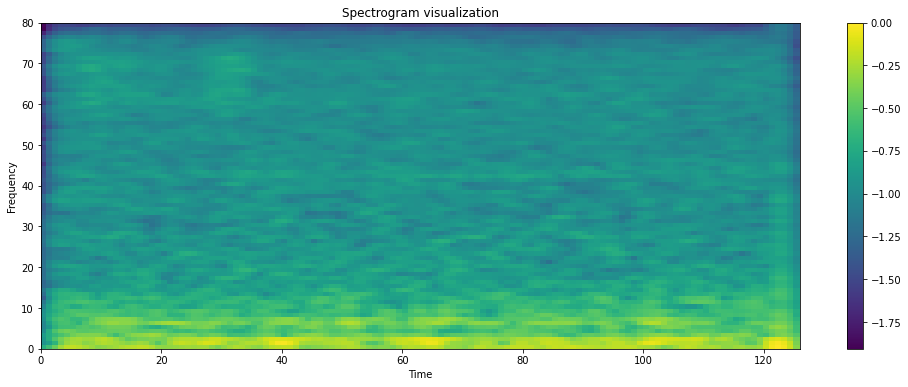

Model: "AttRNNSpeechModel80K"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 126, 1)] 0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 126, 80, 1)   0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 63, 40, 32)   320         permute[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 63, 40, 32)   128         conv2d[0][0]                     
_______________________________________________________________________________

In [13]:
classes=12
dict={
    0 : "down", 
    1 : "go",
    2 : "left",
    3 : "no",
    4 : "off",
    5 : "on",
    6 : "right",
    7 : "stop",
    8 : "up",
    9 : "yes",
    10 : "silence",
    11 : "unknown"
}


spectrogram = load_and_preprocess_data_librosa_mel_spectrogram("output.wav")

print(spectrogram.shape)
plt.figure(figsize=(17, 6))
plt.pcolormesh(spectrogram[:,:,0])
plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')
plt.colorbar()
plt.show()

with tf.device("/cpu:0"):
#     model = AttRNNSpeechModel80K((80, 126, 1), classes)

#     model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    model = tf.keras.models.load_model('ModelEntireDatasetPartitioned_AttRNNSpeechModel80K_0.512_cl.h5')

    model.summary()

In [4]:
spectrogram=np.resize(spectrogram,(1,80,126,1))
with tf.device("/cpu:0"):
    prediction = model.predict(spectrogram)

print(prediction)

[[2.6820567e-06 9.9900812e-01 9.7727082e-08 6.1572988e-05 1.3697664e-06
  2.0819009e-06 5.4158392e-07 2.3819595e-07 9.2094386e-05 3.1382626e-06
  3.9301409e-10 8.2811754e-04]]


In [5]:
print(dict[np.argmax(prediction)])
print(np.max(prediction))


go
0.9990081
